In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()                

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1: Do smokers have higher insurance charges than non-smokers?

H0 - There is no significant difference between the charges of non-smokers and smokers

H1 - There is a significant difference between the charges of non-smokers and smokers

Slignificance Level (Alpha) = 0.05

Test type - 2 Sample T-Test

In [3]:
# check how many customers in each group
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
# split data into two groups
non_smoker = df.loc[df['smoker']=='no'].copy()
smoker = df.loc[df['smoker']=='yes'].copy()

In [5]:
# isolate chargers in each data set
non_smoker_charges = non_smoker['charges']
smoker_charges = smoker['charges']

In [6]:
smoker_charges.head()

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

In [7]:
# check for outliers - ns
zscores = stats.zscore(non_smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [8]:
# remove outliers - ns
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]

In [9]:
# check for outliers - s
zscores = stats.zscore(smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [10]:
# check normality - ns
results_non_smoker_charges = stats.normaltest(non_smoker_charges)
results_non_smoker_charges

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [11]:
# check normality - s
results_smoker_charges = stats.normaltest(smoker_charges)
results_smoker_charges

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

The p-values for both groups are below 0.05 which means the data is not normal, however,the sample size of each group is large enough (>15) to proceed without satisfying this test.

In [12]:
# check equal variance
result = stats.levene(non_smoker_charges, smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

The two samples do not have equal variance therefore I will include equal_var=False when performning the t-test

In [13]:
result = stats.ttest_ind(non_smoker_charges, smoker_charges, equal_var=False)
result

Ttest_indResult(statistic=-33.732305987092516, pvalue=2.575322662587431e-104)

The p-value is smaller than alpha (0.05) so we can reject the null hypothesis and accept that there is a significan difference between the charges of non-smokers and smokers

In [14]:
mean_ns = np.mean(non_smoker_charges)
mean_s = np.mean(smoker_charges)

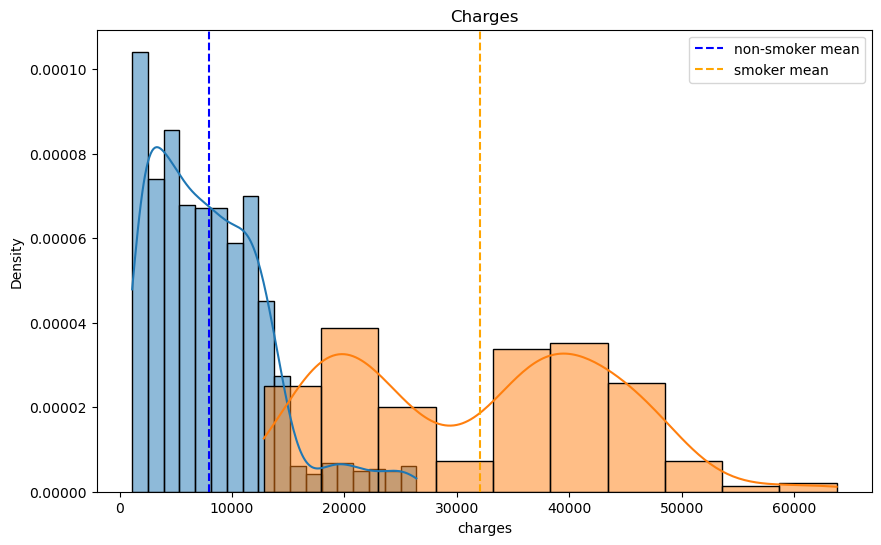

In [15]:
# visualize distribution of each group
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x=non_smoker_charges, stat='density',kde=True)
ax.axvline(mean_ns, color='blue',ls='--', label='non-smoker mean')

sns.histplot(x=smoker_charges, stat='density',kde=True)
ax.axvline(mean_s, color='orange', ls='--', label='smoker mean')

ax.set_title('Charges')
ax.legend();

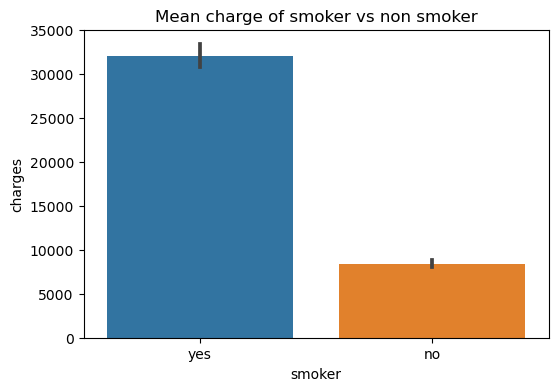

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=df['smoker'],y=df['charges'])
ax.set_title('Mean charge of smoker vs non smoker');

From the two visualisations above it can be seen that the average charge of smokers is much larger than that of non-smokers

## Q2:Are men more likely to smoke than women?

H0 - The probability of men smoking is 0.5

H1 - The probability of men smoking is different than 0.5

Slignificance Level (Alpha) = 0.05

Test type - Binomial Test

Assumptions:
* There are 2 possible outcomes (mmale/female)
* The probability of success is constant
* The trails are independent

In [17]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [18]:
outcomes_male = df.loc[(df['smoker']=='yes') & (df['sex']=='male')]['sex'].count()
outcomes_female = df.loc[(df['smoker']=='yes') & (df['sex']=='female')]['sex'].count()

In [19]:
outcomes = [outcomes_male, outcomes_female]
p_value = stats.binom_test(outcomes, p=0.5)
p_value

C:\Users\x471074\AppData\Local\Temp\ipykernel_20660\1098590944.py:2: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(outcomes, p=0.5)


0.009259938768714322

The p value is smaller than 0.05 and the null hypothesis can be rejected. The alternative hypothesis that the probability of men smoking is different than 0.5 is accepted. 

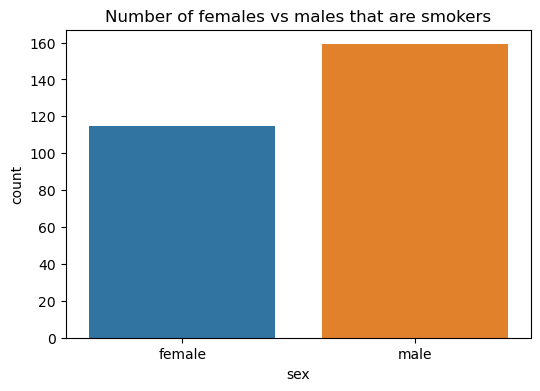

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df.loc[df['smoker']=='yes'], x='sex')
ax.set_title('Number of females vs males that are smokers');

The count plot above indicates that the likelhood of males being smokers are higher than females

## Q3:Do different regions have different charges, on average?

H0 - Different regions have the same charge

H1 - Different regions have different charges

Slignificance Level (Alpha) = 0.05

Test type - One Way ANOVA

In [21]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [22]:
# create group dictionary
groups = {}

# loop through unique regions
for i in df['region'].unique():
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save data in dictionary
    groups[i] = data

In [23]:
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [24]:
# normality test on each group
norm_results = {}

for i, data in groups.items():
    stat, p = stats.normaltest(data)

    # save p value, test statisticts and size of group
    norm_results[i] = {'n': len(data),
                       'p': p,
                       'test stat':stat}

In [25]:
# convert dict to df and Transform
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [26]:
norm_results_df['sig'] = norm_results_df['p'] < 0.05
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Each region does not have a normal distribution, however, the number of samples in each group is greater than 15 so I will proceed with this test.

In [27]:
# testing assumptions of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

The p value is < 0.05 indicating that the null hypothesis stating that the regions have equal variance is rejected and the alternative hypothesis indicating that the regions have different variences is accepted. I will proceed testing with a Welch ANOVA for hypothesis testing and a Games-Howell test to compare groups against one another.

In [28]:
pg.welch_anova(dv='charges', between='region', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,region,3,740.95703,2.608068,0.050593,0.006634


The p value is just over 0.05 so the null hypothesis stating that different regions have the same charge is accepted.

In [29]:
# use Games Howel test to compare groups
pg.pairwise_gameshowell(dv='charges', between='region', data=df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,northeast,northwest,13406.384516,12417.575374,988.809142,876.495552,1.128139,646.753468,0.672260,0.088466
1,northeast,southeast,13406.384516,14735.411438,-1329.026921,962.947944,-1.380165,679.413390,0.512241,-0.104003
2,northeast,southwest,13406.384516,12346.937377,1059.447139,895.548855,1.183014,646.647993,0.637819,0.092763
3,northwest,southeast,12417.575374,14735.411438,-2317.836064,955.749447,-2.425150,677.642458,0.073356,-0.182498
4,northwest,southwest,12417.575374,12346.937377,70.637997,887.804041,0.079565,646.813138,0.999819,0.006234
5,southeast,southwest,14735.411438,12346.937377,2388.474060,973.252437,2.454116,683.096482,0.068257,0.185107


Each comparison p_value is greater than 0.05 confirming that the regions have the same charges

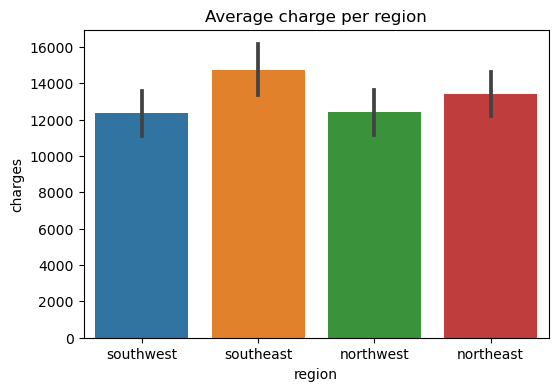

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=df, x='region', y='charges')
ax.set_title('Average charge per region');

As seen from the bar plot above, each region has a similar average charge

In [31]:
# test git ignore
df_copy = df.copy()